<a href="https://colab.research.google.com/github/GuptaNavdeep1983/CS767/blob/main/767_assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from enum import Enum
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

In [46]:
df = pd.read_csv("./Assignment_3_Hitters.csv")
df.rename( columns={'Unnamed: 0':'hitter_name'}, inplace=True )

# convert categorical values using one hot encoding
df = pd.get_dummies(df, columns=['League', 'Division', 'NewLeague'], prefix=["League_is", "Division_is", "NewLeague"] )

# separate training and test datasets
X_train = df.loc[~df.isnull().any(axis=1), ~df.columns.isin(['Salary', 'hitter_name'])]
y_train = df.loc[~df.isnull().any(axis=1), ['Salary']]
X_test = df.loc[df.isnull().any(axis=1), ~df.columns.isin(['Salary', 'hitter_name'])]
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [47]:
## Standardization across features
scaler_training = StandardScaler() 
scaler_training.fit(X_train)
scaled_values_training = scaler_training.transform(X_train)
scaled_values_testing = scaler_training.transform(X_test)

X_train = pd.DataFrame(scaled_values_training, columns=[*X_train.columns.values])
X_test = pd.DataFrame(scaled_values_testing, columns=[*X_test.columns.values])

In [3]:
number_of_features = len(X_train.columns.values)
final_output = []

In [4]:
class Regularization(Enum):
     L2 = 1
     Lasso = 2
     No_regularization = 3

In [58]:
def predict(row, weights, bias):
  output = bias
  for index, weight in enumerate(weights):
    output += weight * row[index]
    # leaky ReLu
  output = output if output > 0.0 else output * 0.05
  # print(output)
  return output

# Lasso Regularizer
def lasso_regularization(weights, lambda_val):
  return sum([abs(weight) for weight in weights]) * lambda_val
# L2 regularizer
def l2_regularization(weights, lambda_val):
  return sum([weight**2 for weight in weights]) * (lambda_val/2)

# get regularizer component based on choice of regularizer and weights and lambda value 
def calculate_regularzation_component(regularization, weights, lambda_val):
  if regularization == Regularization.L2:
    return l2_regularization(weights, lambda_val)
  elif regularization == Regularization.Lasso:
    return lasso_regularization(weights, lambda_val)
  else:
    return 0

# initialize weights using He initialization
def initialize_weights():
  return [random.uniform(-2,2)* math.sqrt(2/number_of_features) for i in range(number_of_features)]
# train model
def train_model(X_train, y_train, num_epochs, learning_rate, lambda_val, regularization_component, alpha_val=0.9, batch_size=12):
  # weights for all the features 
  weights = initialize_weights()
  bias = 0
  epoch = 0
  plot_values = []
  while epoch < num_epochs:
    mse = 0.0
    total_gradient = [0 for _ in range(number_of_features)]
    mini_batch = X_train.sample(n = batch_size, random_state=42)
    regularization = calculate_regularzation_component(regularization_component, weights, lambda_val)
    for rowIndex, row in mini_batch.iterrows():
      # print(row)
      # Predict
      predicted_value = predict(row, weights, bias)
      # Calculate error
      error = (y_train.loc[rowIndex,'Salary'] - predicted_value)
      # Add regularizer
      error_with_regularization = error + regularization
      # sum up all errors
      mse += error**2
      # add up gradients
      total_gradient = [gradient + (error_with_regularization * row[gradient_index]) for gradient_index, gradient in enumerate(total_gradient)] 
    mse_with_regularization = mse + regularization
    # add momentum
    total_gradient = [(alpha_val * gradient) + gradient for gradient in total_gradient] 
    #adjust weights and bias
    bias = bias + learning_rate * (mse_with_regularization/mini_batch.shape[0])
    weights = [weight + learning_rate * (total_gradient[weight_index]/mini_batch.shape[0]) for weight_index, weight in enumerate(weights)]

    epoch = epoch + 1
    plot_values.append((epoch, mse_with_regularization/mini_batch.shape[0]))
    # print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, learning_rate, mse_with_regularization/mini_batch.shape[0]))
  df_plot_values = pd.DataFrame(plot_values, columns=['epoch', 'MSE'])

  
  return weights, bias, df_plot_values

#Learning Rate

To choose the learning rate, checked the graph of MSE vs epoch's and chooses the one with which the MSE is decreasing gradually.

#Underfitting
Choosing the number of iterations only based on training sets as the number of tuples is quite less and after certain iterations, the model tends to perform badly during training itself.

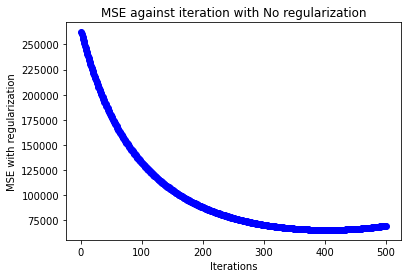

In [65]:
final_output = []
(weights, bias, df_plot_values) = train_model(X_train, y_train, num_epochs=500, learning_rate=0.00001, lambda_val=0.01, regularization_component=Regularization.No_regularization)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with No regularization")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("No_regularization", *weights))


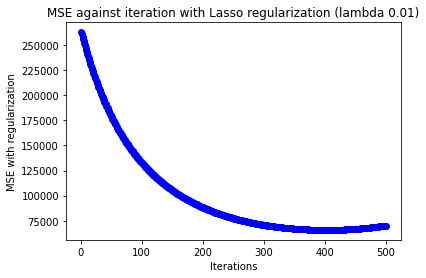

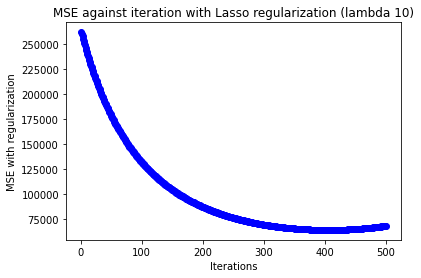

In [66]:
(weights, bias, df_plot_values) = train_model(X_train, y_train, num_epochs=500, learning_rate=0.00001, lambda_val=0.01, regularization_component=Regularization.Lasso)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with Lasso regularization (lambda 0.01)")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("Lasso_regularization_with_lambda_0.01", *weights))
(weights, bias, df_plot_values) = train_model(X_train, y_train, num_epochs=500, learning_rate=0.00001, lambda_val=10, regularization_component=Regularization.Lasso)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with Lasso regularization (lambda 10)")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("Lasso_regularization_with_lambda_10", *weights))

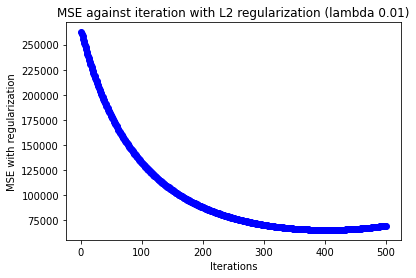

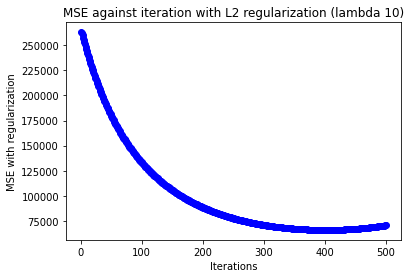

In [67]:
(weights, bias, df_plot_values) = train_model(X_train, y_train, num_epochs=500, learning_rate=0.00001, lambda_val=0.01, regularization_component=Regularization.L2)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with L2 regularization (lambda 0.01)")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("L2_regularization_with_lambda_0.01", *weights))
(weights, bias, df_plot_values) = train_model(X_train, y_train, num_epochs=500, learning_rate=0.00001, lambda_val=10, regularization_component=Regularization.L2)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with L2 regularization (lambda 10)")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("L2_regularization_with_lambda_10", *weights))

In [68]:
df_output = pd.DataFrame(final_output, columns=["Regularization", *X_train.columns.values])
df_output

,Regularization,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_is_A,League_is_N,Division_is_E,Division_is_W,NewLeague_A,NewLeague_N
0,No_regularization,1.206164,1.031589,-0.119755,0.771448,-0.362365,1.377355,1.130248,2.323742,2.404887,0.198199,2.018635,1.339131,2.554870,-0.339266,1.119083,1.133966,0.520935,-0.864326,0.076695,0.026676,1.176670,-0.516724
1,Lasso_regularization_with_lambda_0.01,1.382004,1.136750,-0.558125,0.717494,-0.097004,1.864929,1.359754,1.865528,1.657708,0.055919,1.469097,1.737444,1.965772,-0.090932,1.573912,0.272494,0.476034,-1.088589,0.295165,-0.939447,0.465145,-0.856476
2,Lasso_regularization_with_lambda_10,1.018132,1.693237,-1.310983,1.682161,-0.582744,2.125554,2.947941,2.332862,2.953806,0.650313,3.074723,1.712756,3.633299,-1.004872,2.713710,2.115898,0.400002,-0.765376,0.554393,-0.253244,-0.011593,-0.647849
3,L2_regularization_with_lambda_0.01,0.751725,0.677719,0.180059,0.836216,0.262317,0.883236,1.914273,2.422632,2.074238,0.420411,2.284378,1.274716,1.664010,-0.476801,1.792214,0.419808,0.583531,-0.699431,0.263050,-0.291318,1.056012,-0.792781
4,L2_regularization_with_lambda_10,1.111403,1.409277,-1.056194,0.803016,-0.479526,1.282227,1.619555,1.947684,1.617038,-0.354100,2.297158,0.799769,2.367771,-0.587678,1.546880,1.162255,0.861196,-0.240097,0.693194,-0.028975,0.354662,-0.904008


#Observations
With Lasso regularization, the features which are contributing less towards the prediction, are drifting towards 0.
With L2 regularization and lambda value smaller, the correlated features are equally faired, but with higher lambda value, the correlated features are drifted away from each other.